<h1><center><font size="6"> Kaggle Project: Credit Card Fraud Detection</font></center></h1>

<h2><center><font size="4"> https://www.kaggle.com/mlg-ulb/creditcardfraud </font></center></h2>

This notebook compares the model with and without handeling class imbalance problem.

## Table of  Contents
1. [Initialization](#1)
    1. [Load packages](#11)
    1. [Define Metadata](#12)   
1. [Load Processed Data and Validate](#2)
1. [Check Class Distribution](#3)
1. [Prepraring Data before Handeling Class Imbalance](#4)
    1. [Normalizing numerical variables](#41)
    1. [Feature - Target Split](#42)
    1. [Train-Test Split](#43) 
1. [Evauate classification Model without handling Class Imbalance](#5)
    1. [Initialize RF Classifier](#51)
    1. [Evaluate RF Classifier Perfomance](#52)
    1. [Precision at Recall-Threshold Evaluation Metric](#53)
1. [Data Skewness Correction via Resampling Strategies](#6)
    1. [Undersampling - RandomUnderSampler](#61)
    1. [Oversampling - SMOTE](#62)
    1. [Hybrid Oversampling and Undersampling - SMOTEENN](#63)
    1. [Custom Oversampling Method](#63)
1. [Conclusion](#7)


## <a id='1'>1. Initialization</a>  

### <a id='11'>A. Load Packages</a>  

In [1]:
import os
import sys

import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn


# split into train and test set 
from sklearn.model_selection import train_test_split

# Classifier
from sklearn.ensemble import RandomForestClassifier

# Performance evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from collections import Counter

# Resampling Techniques
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 


### <a id='12'>B. Define Metadata</a>  

In [2]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'Class'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['Non-Fraud', 'Fraud']

input_file_name = 'creditcard.csv'

## <a id='2'>2. Load Processed Data and Validate</a> 

In [3]:
df = pd.read_csv('C:/Behnaz/Data Science/Kaggle Dataset/' + input_file_name)
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
138552,82718.0,0.701452,-0.459548,0.166602,1.281531,0.352891,2.163467,-0.548278,0.749445,0.558495,...,0.124997,0.496999,-0.171507,-1.393277,0.328284,-0.158921,0.114431,0.046147,138.88,0
73420,55128.0,-0.613953,1.158226,1.164120,0.035502,-0.069853,-1.060066,0.595327,0.000539,-0.031549,...,-0.307787,-0.804464,0.008912,0.301456,-0.145786,0.080578,0.347939,0.160320,5.99,0
245173,152635.0,-1.129981,0.091727,2.183192,-0.123982,-0.037354,0.463186,1.104135,0.038478,0.247361,...,0.010187,-0.254171,0.104183,0.620697,0.558423,-0.848670,-0.163536,-0.129269,185.00,0
194601,130674.0,2.134988,-0.820859,-1.219295,-0.953809,-0.662976,-1.047696,-0.467734,-0.239688,-0.722168,...,0.516461,1.440337,-0.018623,0.074134,0.118915,0.055080,-0.040642,-0.072265,28.85,0
160739,113593.0,-0.186318,0.956181,0.104704,-0.661320,0.361138,-1.078314,0.948649,-0.145188,0.278507,...,-0.312106,-0.686765,0.067470,-0.141956,-0.446068,0.155112,0.354829,0.150550,7.88,0


Let's validate the dataset to see if  
- there are some unwanted headers.
- there are any problem in the tail.

In [4]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.tail(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


#### $\rightarrow$ No trouble with loading the data, the head and tail.

## <a id = 3 > 3. Check Class Distribution

0    284315
1       492
Name: Class, dtype: int64

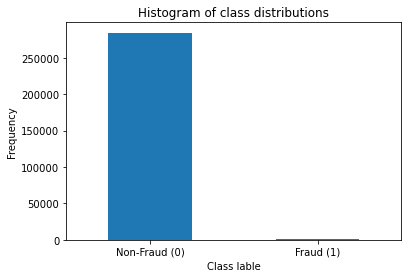

In [6]:
plt.figure(figsize=(6,4))
pd.value_counts(df[target_class_name]).plot.bar()
plt.title('Histogram of class distributions')
plt.xlabel('Class lable')
plt.xticks([0,1],['Non-Fraud (0)', 'Fraud (1)'],rotation=0)
plt.ylabel('Frequency')

df[target_class_name].value_counts()

In [7]:
print ('Percentage of each class in the dataset:\n{}'.format(round(df['Class'].value_counts()/len(df)*100,3)))

Percentage of each class in the dataset:
0    99.827
1     0.173
Name: Class, dtype: float64


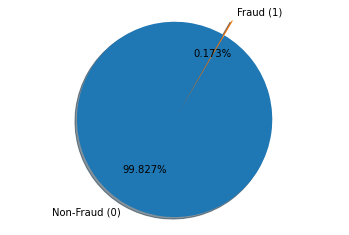

In [8]:
#visualizing in pie chart
labels = 'Non-Fraud (0)', 'Fraud (1)'
explode = (0, 0.173)

fig1, ax1 = plt.subplots()
ax1.pie(df['Class'].value_counts(), explode=explode, labels=labels, autopct='%1.3f%%',
        shadow=True, startangle=60)
ax1.axis('equal')
plt.show()

#### 99.827% of the dataset is comprised of non-fraud samples $\rightarrow$ The dataset is highly imbalanced

#### What is the problem with class imbalance?!
- Most machine learning algorithms assume data equally distributed.
- When there is an unequal distribution of classes in the training dataset, ML classifiers tend to be more biased towards the majority class, causing bad classification of the minority class. 

To illustrate, a classifier may not learn the underline pattern of the dataset and blindly predict that everything belongs to the majority class to maximizes the accuracy. In this dataset, the majority class is non-fraud (class 0). Therefore, class imbanace dataset causes bad classification of fraud samples and a selected classifier may predict everything belongs to non-fraud class, which is not desired. Therefore, we need to check the class distribution in order to

- Select a proper evaluation metric and classification model OR handel the class imbalance problem using resampling techniques. 

## <a id = 4 > 4. Prepraring Data before Handeling Class Imbalance

## <a id = 41 > A. Normalizing numerical variables </a>

    - Scaling has the effect of squeezing all data range into a tight range. 
        
    - For tree-based ML models such as Random Forest scaling/normalization is not required (RF classifier is used here). 

## <a id='42'>B. Feature - Target Split</a> 

In [9]:
X = df.drop(target_class_name, axis=1)
y = df[target_class_name]

## <a id='43'>C. Train-Test Split</a> 

Train/Test split is done before using data augmentation techniques since
- The Test set should have a valid representation of how the unseen unlabelled production data will occur during which time we won't have the luxury of correcting the class imbalance problem.


*Note: When we have a big dataset and want to model faster, we can convert the pandas dataframe into a numpy array using to_numpy. Otherwise, it doesn't matter which data structure we use.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# random_state=42 to be able to reproduce the set.

In [11]:
print('\n Train set Shape: {}'.format(X_train.shape),'\n Number of fraud samples in Train set: {}'.format(sum(y_train)),
                                                                                                                     
       '\n \n Test set Shape: {}'.format(X_test.shape),'\n Number of fraud samples in Test set: {}'.format(sum(y_test)))


 Train set Shape: (227845, 30) 
 Number of fraud samples in Train set: 394 
 
 Test set Shape: (56962, 30) 
 Number of fraud samples in Test set: 98


## <a id = 5 > 5. Evauate classification Model without handling Class Imbalance

## <a id='51'>A. Initialize RF Classifier</a> 

In [12]:
# Initialize a classifier object with default params
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## <a id='52'>B. Evaluate RF Classifier Performance</a> 


In [13]:
# Custom Evaluation Function:
def classification_Evaluation_metrics_function(X_test, y_test, classifier, ModelSpe = 'Clarification', metrics_df_flag=True):
    
    '''
    Inpute: 
    X_train - target dataframe
    y_train - target labels
    sklearn classifier object that has been fitted with the training data outside of the function; 
    Model specifications that we want to avaluate its result.
    
    Logic: Calculates and displays the Accuracy, Classification report, ROC Curve, Confusion Matrix.
    
    Returns: If metrics_df flag is set, return dictionary containing relevant metrics for classification.
    
    ''' 
    # Accuracy
    Acc = round(classifier.score(X_test, y_test),2)   
    print("Accuracy of " + ModelSpe + " =  {} % ".format(Acc * 100))
    
    # Precision, Recall, F1-Score, Support
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test,y_pred,target_names=labels))

    # --------------------------------------------------------------------------------------------------------------------------
    # ROC Curve
    FP_rate, TP_rate, threshold = roc_curve(y_test, y_pred)  
    y_pred_Proba = classifier.predict_proba(X_test)[:,1]
                   
    
    f = plt.figure(1)
    plt.figure(figsize=(10,6))
    plt.plot([0, 1], [0, 1], 'c--')
    plt.plot(FP_rate, TP_rate, 'g-', linewidth=3)
    plt.title('Receiver Operating Characteristic (ROC) Curve - ' + ModelSpe, fontsize=18)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)    
    plt.axis([-0.01,1,0,1])
    f.show()
    
    roc_auc_val = float("{0:.2f}".format(roc_auc_score(y_test, y_pred_Proba)))
    print('The ROC-AUC Score ({}) = {}'.format(ModelSpe, roc_auc_val))

    # --------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    confusion_matrix_test = confusion_matrix(y_test, y_pred)
    
    g = plt.figure(1)
    x_axis_labels = ['Non-Fraud','Fraud'] # labels for x-axis
    y_axis_labels = ['Non-Fraud','Fraud'] # labels for y-axis
    ax = sn.heatmap(confusion_matrix_test,cmap="YlGnBu", annot=True, annot_kws={"size": 16},xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size
    plt.title('Confusion Matrix - '+ ModelSpe, fontsize = 20) # title with fontsize 20
    plt.xlabel('Predicted Label', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True Label', fontsize = 15) # y-axis label with fontsize 15
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
    g.show()

    # --------------------------------------------------------------------------------------------------------------------------
    # Note: his part will be exlained in section C.
    # The precision value when recall is just above the recall_threshold    
    # from sklearn.metrics import precision_recall_curve  
    precision, recall, _ = precision_recall_curve(y_test, y_pred_Proba)   
    Precision_at_Recall = precision[recall>0.85][-1]
    # --------------------------------------------------------------------------------------------------------------------------
    if metrics_df_flag:
        # The precision value when recall is just above the recall_threshold
        metrics_dict = {}

        

        # Metrics from the classification report
        # We are only interested in the minority class which is 1
        metrics_dict['Pos_Precision'] = classification_report(y_test, y_pred, output_dict=True)['1.0']['precision']
        metrics_dict['Pos_Recall'] = classification_report(y_test, y_pred, output_dict=True)['1.0']['recall']
        metrics_dict['Pos_F1'] = classification_report(y_test, y_pred, output_dict=True)['1.0']['f1-score']

        # Metric from the ROC AUC curve
        metrics_dict['ROC-AUC'] = roc_auc_val

        
        # Metrics from the confusion matrix
        metrics_dict['TN'] = confusion_matrix_test[0][0]
        metrics_dict['TP'] = confusion_matrix_test[1][1]
        metrics_dict['FN'] = confusion_matrix_test[1][0]
        metrics_dict['FP'] = confusion_matrix_test[0][1]

        metrics_dict['Precision_at_Recall (85%)'] = Precision_at_Recall
        
        return metrics_dict

Accuracy of without handeling class Imb. =  100.0 % 
               precision    recall  f1-score   support

Non-Fraud (0)       1.00      1.00      1.00     56864
    Fraud (1)       0.94      0.82      0.87        98

     accuracy                           1.00     56962
    macro avg       0.97      0.91      0.94     56962
 weighted avg       1.00      1.00      1.00     56962

The ROC-AUC Score (without handeling class Imb.) = 0.96


KeyError: '1.0'

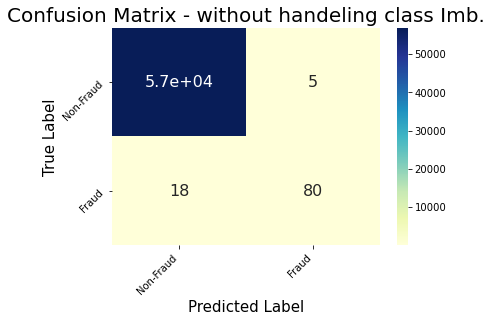

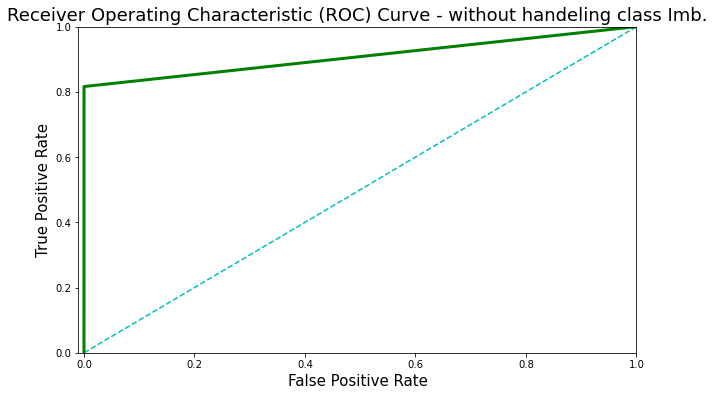

In [14]:
Metrics_Imb = classification_Evaluation_metrics_function(X_test, y_test, classifier, 
                                                 ModelSpe = 'without handeling class Imb.', metrics_df_flag=True)

#### Summary of the results:
- The Accuracy of 100%, which obtained by the model can be the result of highly imbalanced datset. Therefore, we need to do more investigation considering other metrics.


- In imbalanced dataset we need to check the performance of the model for the minority class, which is "Fraud" in this case. Confusion matrix shows that

  - TP is equal to 80. It means that the model corretly perdicts 80 fraud out of actual 98 fraud. Threfore, we have a true positive rate (Recall) 82%. (Note: Recall = $\frac{TP}{TP+FN}$).
  
  - TN is equal to 56859.  It means that the model corretly perdicts 56859 non-fraud out of actual 56864 fraud and only 5 samples are misclassified (FP = 5). Threfore, precision is 94%. (Note: Precision = $\frac{TP}{TP+FP}$).
  
  
- F1-score that is generated by the confusion matrix is preffered since it is sensitive to class distribution unlike Accuracy. However, F1-score cannot differntiate between a good recall or good precision, since F1 score combines precision and recall into a single number: <center>$𝐹_1=  \frac{(Precision.𝑅𝑒𝑐𝑎𝑙𝑙)}{(Precision+𝑅𝑒𝑐𝑎𝑙𝑙)} = \frac{(2.𝑇𝑃)}{(2.𝑇𝑃+𝐹𝑁+𝐹𝑃)}$</center> 
Therefore, we can use a custom metric to handle this issue.



In fraud detection, the cost of FN is high and detecting fraud cases are more important at the cost of higher FP. In other words, higher recall score is desired and these category of problems are called "Recall-Oriented tasks". The default threshold of RF classifier for interpreting probabilities to class labels is 50%. This defualt threshold will not provide us the desired performance metric. A simple approach to improve the performance of a classifier that predicts probabilities on an imbalanced classification problem is to tune the threshold used to map probabilities to class labels, which is called "Threshold-Moving". However, Threshold-Moving can cause problem when we want to compare different classifiers using different probability cutoff! The Following custom metric can address the mentioned problem (refer to the following URL to find more details:  https://towardsdatascience.com/selecting-the-right-metric-for-skewed-classification-problems-6e0a4a6167a7).



## <a id='53'>C. Precision at Recall-Threshold Evaluation Metric </a> 


In [ ]:
def precision_at_Recall_Threshold_function(y_test, predicted_proba, Recall_Threshold=0.85):
    '''
    Inputs: The true labels, predicted probabilities and the recall threshold for which precision needs to be computed
    
    Logic: Using the precision recall curve method from sklearn. Then, the precision at a given Recall_Threshold is calculated.
    
    Returns: "the first Precision score when Recall is greater than Recall_Threshold." 
    
    '''
    # from sklearn.metrics import precision_recall_curve    
    precision, recall, _ = precision_recall_curve(y_test, predicted_proba)    
    return precision[recall>Recall_Threshold][-1]

In [ ]:
# Predict class probabilities for X_test.
predicted_proba = classifier.predict_proba(X_test)[:,1]
precision_at_Recall = precision_at_Recall_Threshold_function(y_test, predicted_proba, Recall_Threshold=0.85)
precision_at_Recall

Before handling class imbalance problem, a dataframe is initialized to better visualize the results of different techniques.

In [ ]:
Metrics_df = pd.DataFrame(
columns = ['Pos_Precision','Pos_Recall','Pos_F1',
           'ROC-AUC','FN','TP','FP','TN','Precision_at_Recall (85%)'],
index = ['Imb. dataset','Undersampling','Oversampling','Hybrid','Custom'])

# Metrics_df

# Depending on the business problem, one or more of these metrics will be more important.
# The prefixes exist for the Precision, Recall and F1 since here we are only interested in the positive class.

In [ ]:
Metrics_df.loc['Imb. dataset'] = Metrics_Imb
# Metrics_df

## <a id = 6> 6. Data Skewness Correction via Resampling Strategies

Data always beats algorithms! 

Given that our dataset is heavily skewed in favor of the negative class (ie non-fraud), any technique that brings the ratio closer to 50:50 should theoretically improve the performance.

The theoretical reason for favoring the 50:50 ratio is that the results will be no worse than what was obtained with natural class distributions.
https://www.researchgate.net/publication/2364670_The_Effect_of_Class_Distribution_on_Classifier_Learning_An_Empirical_Study

Following approaches can be used to handel class imbalance: undersampling and oversampling
    
- Undersampling: samples of the majority class (non-fraud samples) are reduced until the remaining data is balanced.

- Oversampling: The minority class (fraud samples) are repeatedly sampled until the synthetic data is balanced.

- Hybrid approach: Both classes are simultaneously sampled until the minority class reaches a threshold.

## <a id = 61> A. Undersampling - RandomUnderSampler

Here, the RandomUnderSampler method randomly downsamples the majority class (non-fraud samples/ class 0) until the ratio of class 0 and class 1 are the same.

In [ ]:
def HandlingClassImb_RF_Performance_function(X_train, y_train, X_test, y_test, ResampleMethod, Recall_Threshold=0.85):
    
    '''
    Inputs: The train and test data; Resample Technique; Recall_Threshold
    
    Logic: Trains a random forest classifier with default params and outputs the classification report & confusion matrix
    
    Displays: The confusion matrix and classification report
    
    Returns: Resampled Train set and the metrics_dict containing the evaluation metrics
    '''
    if ResampleMethod == 'Custom':
        # Refer to Section 6.D to find more detailes about the following function.
        X_resampled_train, y_resampled_train = Custom_resampling_function(X_train, y_train, pos_upsampling_ratio=4, 
                                                                  neg_upsampling_ratio=2)
 
    else:
    
        # Generate the resampled data using one of the imblearn methods
        X_resampled_train, y_resampled_train = ResampleMethod.fit_sample(X_train, y_train)
    
    print('Size of resampled train sets:')
    print(X_resampled_train.shape,sum(y_resampled_train))
    
    from sklearn.ensemble import RandomForestClassifier

    # Initialize a classifier object with default params
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_resampled_train, y_resampled_train)

    # Display the classification report on the Test data
    metrics_dict = classification_Evaluation_metrics_function(X_test, y_test, classifier, ModelSpe = 'Clarification',
                                                              metrics_df_flag=True)
    
    return  metrics_dict#, X_resampled_train, y_resampled_train


In [ ]:
Metrics_df.loc['Undersampling'] = HandlingClassImb_RF_Performance_function(X_train, y_train, X_test, y_test,  RandomUnderSampler(random_state=42), Recall_Threshold=0.85)

## <a id = 62> B. Oversampling - SMOTE    

A popular oversampling technique is Synthetic Minority Over-sampling Technique (SMOTE). This approach effectively forces the decision region of the minority class to become more general. SMOTE instead of sampling with replacement of the original minority class, generates synthetic data for the minority class. In fact, SMOTE proceeds by joining the points of the minority class with line segments and then places artificial points on these lines. SMOTE steps can be summarized as follows:

- Select a minority class input vector.
- Find its k nearest neighbors.
- Choose one neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor.
- Repeat the steps until data is balanced.

Refer to the following paper for more detail: https://jair.org/index.php/jair/article/view/10302/24590
    

In [ ]:
Metrics_df.loc['Oversampling'] = HandlingClassImb_RF_Performance_function(X_train, y_train, X_test, y_test,SMOTEENN(sampling_strategy = 'all' ,random_state=42), Recall_Threshold=0.85)

## <a id = 63> C. Hybrid Oversampling and Undersampling - SMOTEENN

SMOTEENN, combines the SMOTE upsampling technique with Edited Nearest Neighbors (ENN) undersampling. ENN first oversamples both the minority and majority class until they are balanced. Then the Tomek links are removed. This prevents the majority class from 'intruding' too deep into the minority class space. 

Refer to the following papers for more details:

https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.combine

https://pdfs.semanticscholar.org/c1a9/5197e15fa99f55cd0cb2ee14d2f02699a919.pdf

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4309452

In [ ]:
Metrics_df.loc['Hybrid'] = HandlingClassImb_RF_Performance_function(X_train, y_train, X_test, y_test,SMOTE(random_state=42), 
                                                                    Recall_Threshold=0.85)

## <a id = 63> D. Custom Oversampling Method

This Method, which only applied for binary classification, is based on a code in Kaggle: 

This method helps to simultaneously oversample both Classes using samples from known x_train instead of introducing new random samples.
The steps of this Custom method can be summarized as follows:
        1. For each class:
            1.2. Choose upsapmling rate.   
            1.3. For i in range upsapmling rate.
                1.3.1 Filter the x_train to contain only features for class 0 or class 1.
                1.3.2 x_train_copy  ←  filtered x_train.
                1.3.3 Creat indices of number of rows in x_train_copy (ids).
                1.3.4 For each column C in x_train_copy.
                    1.3.4.1 Shuffle ids.
                    1.3.4.2 Column C of x_train_copy  ←  column C of x_train_copy with ids indices.
                1.3.5 Append x_train_copy to the output.
        2. Create the synthetic feature by stacking output arrays of two classess (row wise).
        3. Create an array of zeros and ones with the same number of rows as the synthetic feature. 
        4. Vertically join the synthetic feature and lables with the original X_train and y_train to obtain X_resample and y_resample, respectively.
        5. Shuffle obtained X_resample and y_resample.



In [ ]:
def Custom_resampling_function(X_train, y_train, pos_upsampling_ratio=4, neg_upsampling_ratio=2): 
    '''
    Args:
    X_train - feature dataframe
    y_train - target series
    pos_upsampling_ratio - how much to upsample the positive class by
    neg_upsampling_ratio - how much to upsample the negative class by

    Logic: The two separate upsampling ratios allow you to independently control how much each class gets sampled
    While this was originally created to augment both classes simultaneously, 
    it can be used to deliberately upsample one class but not the other    

    Returns: augmented feature and target columns

    ''' 
    # Set the seed to be able to replicate the results
    np.random.seed(42)
    # Convert the input dataframes into arrays
    x, y = X_train.values, y_train.values
    # create empty arrays for the positive and negative rows in the input data
    xs, xn = [], []
    # -------------------------------- This section segments augments the positive class 
    for i in range(pos_upsampling_ratio-1):

        # Select all rows of x, which belong to positive class and save them in x_train_copy
        mask = y>0
        x_train_copy = x[mask].copy()
        # Create an array of indices from the number of rows 
        ids = np.arange(x_train_copy.shape[0])

        # In this inner loop, the rows of x_train_copy are shuffled for each column
        for c in range(x_train_copy.shape[1]):

            # The following line shuffles the indices in place
            np.random.shuffle(ids)
            # Update the column c of x_train_copy using the shuffled ids
            x_train_copy[:,c] = x_train_copy[ids][:,c]

        # Appand the updated x_train_copy to the output.
        xs.append(x_train_copy)
    # -------------------------------- This section segments augments the negative class
    for i in range(neg_upsampling_ratio-1):

        # Select all rows of x, which belong to positive class and save them in x_train_copy
        mask = y==0
        x_train_copy = x[mask].copy()
        # Create an array of indices from the number of rows 
        ids = np.arange(x_train_copy.shape[0])

        # In this inner loop, the rows of x_train_copy are shuffled for each column
        for c in range(x_train_copy.shape[1]):
            # Shuffle the indices in place
            np.random.shuffle(ids)
            # Update the column c of x_train_copy using the shuffled ids
            x_train_copy[:,c] = x_train_copy[ids][:,c]

        # Appand the updated x_train_copy to the output.
        xn.append(x_train_copy)

    # ------------------------------------------------------------------------------------------------------------------------------

    # Stack output arrays (xs and xn) in sequence vertically (row wise)
    xs = np.vstack(xs)
    xn = np.vstack(xn)

    # Create an array of 1s and 0s with the same number of rows as the corresponding synthetically created feature matrices
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])

    # Vertically join the synthetic feature and lables with the original x_train and y_train to obtain x_resample and y_resample, respectively.
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])

    # Convert the arrays to dataframes
    X_resampled_df = pd.DataFrame(data=x, columns=X_train.columns)
    y_resampled = pd.Series(y)

    # Shuffle the merged dataframe so that 1s and 0s are not right below each other
    X_resampled_df, y_resampled = shuffle(X_resampled_df, y_resampled)

    return X_resampled_df, y_resampled

In [ ]:
Metrics_df.loc['Custom'] = HandlingClassImb_RF_Performance_function(X_train, y_train, X_test, y_test,'Custom',
                                                                    Recall_Threshold=0.85)

## <a id = 7 > 7. Conclusion

In [ ]:
Metrics_df

- Underdampling: Despite a good Recall score of 81%, the model provides very small Precision of 4% due to large FP. This results small F1 score of 8%. 
- Oversampling (SMOTE): Compared to Undersampling technique, SMOTE provides more acceptable results and better Precision_at_Recall score.
- Hybrid: This resampling techniques provides higher and lower Precision_at_Recall score compared to Undersampling and oversampling technique, respectively.
- Custom: This method outperforms other resampling methods.
###### In summary, the results show that the model without handling class imbalance provides higher Precision_at_Recall score.  Therefore, we can use the Imb. dataset model to have better performance and also keep the model simple. However, before making our final decision, we still can consider more investigation Such as Feature Engineering, Hyperparameter Tuning, and ensamble learning.